In [4]:
# initialisation cell

import os
import sys
from os import path, listdir
from collections import namedtuple
from functools import reduce

import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

# Use simpson's rule for calculating AUC
from scipy.integrate import simpson

from process_results import recursive_file_search, calculate_average_baselines

# https://gist.github.com/thriveth/8560036 color-blind friendly colors
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Set font settings globally
font = {
        "family": "sans-serif",
        "weight": "normal",
        "size": 12
       }

mpl.rc("font", **font)

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle)

# plt.rcParams['figure.constrained_layout.use'] = True
# plt.xlim(xmin=0.0)

RESULTS_DIR = path.abspath("../results")

def label_bars(bars, ax, customtxt = "", orientation="v"):
    for bar in bars:
        if customtxt:
            txt = customtxt
        else:
            if orientation == "v":
                txt = bar.get_height()
                xy=(bar.get_x() + bar.get_width() / 2, txt)
                xytxt = (0,1)
                va="bottom"
                ha="center"
            else:
                txt = bar.get_width()
                xy=(txt, bar.get_y() + bar.get_height() / 2)
                xytxt = (1,0)
                va = "center"
                ha = "left"
                
        max_chars = 6
            
        ax.annotate(f"{txt}"[:max_chars], 
                   xy=xy,
                   xytext=xytxt,
                   textcoords="offset points",
                   ha=ha, va=va)
        
def my_bar_plot(ax, values, groups, ylabel, datalabel, title="my bar plot", orientation="v"):
    bar_width = 0.4
    
    # Set all labels
    x_pos = np.arange(len(groups))
    
    if orientation == "v":
        bartype = "bar"
    else:
        bartype = "barh"

    barcall = getattr(ax, bartype)

    if len(values) == 2 and len(datalabel) == 2:
        my_bar = []
        my_bar.append(barcall(x_pos - bar_width/2, values[0], bar_width, label=datalabel[0], rasterized=True))
        my_bar.append(barcall(x_pos + bar_width/2, values[1], bar_width, label=datalabel[1], rasterized=True))
    else:
        my_bar = barcall(x_pos, values, bar_width, label=datalabel, rasterized=True)
    

    if len(groups) > 1:
        max_value = max([subitem for item in values for subitem in item])
    else:
        max_value = max(values)
    
    if orientation == "v":
        ax.set_ylabel(ylabel)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(groups)
        ax.set_ylim(ymax=max_value*1.1)
    else:
        ax.set_xlabel(ylabel)
        ax.set_yticks(x_pos)
        ax.set_yticklabels(groups)
        ax.set_xlim(xmax=max_value*1.1)
    ax.legend(loc="lower left", bbox_to_anchor=(0.0, 1.0), ncol=len(datalabel), borderaxespad=0, frameon=False)
#     ax.set_title(title)

    if isinstance(my_bar, list):
        for bar in my_bar:
            label_bars(bar, ax, orientation=orientation)
    else:
        label_bars(my_bar, ax, orientation=orientation)

    return my_bar

def save_my_figure(fig, figtype: str, machine: str, workload: str):
    figure_loc = path.join(path.dirname(path.realpath(sys.argv[1])), machine, workload)

    os.makedirs(figure_loc, exist_ok=True)
    
    figure_loc = path.join(figure_loc, figtype) + ".png"
    
#     fig.set_size_inches(4,3)
    fig.savefig(figure_loc, transparant=False, facecolor="w", bbox_inches="tight", dpi=300)
    

def find_baselines(x):
    x = path.basename(x)
    return x == "baseline.txt" or x == "baselines.txt"

def round_to_largest_significant_num(x):
    i = 0
    while x > 10:
        x = int(x/10)
        i += 1
        
    return x * 10**i

def my_execution_histogram(ax, runtimes, datalabel="", xlabel="", ylabel="Frequency"):
    assert isinstance(runtimes, pd.Series)
    
    min_runtime = runtimes.min()
    max_runtime = runtimes.max()
    
#     bin_size = abs(max_runtime - min_runtime) / bin_count

    per_25 = runtimes.quantile(0.25)
    per_75 = runtimes.quantile(0.75)
#     Freedman–Diaconis rule
    bin_size = 2 * ((per_75 - per_25) / (len(runtimes)**(1/3)))
    bins = round((max_runtime - min_runtime) / bin_size)
#     bins = [min_runtime + i * bin_size for i in range(bin_count+1)]
        
    ax.hist(runtimes, bins=bins, label=datalabel, alpha=0.5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
#     ax.set_xlim(xmin=min_runtime, xmax=max_runtime)

In [5]:
# data gathering cell

# Find all results
result_filter = lambda x: "processed-" in x
prediction_filter = lambda x: "predictions-" in x

all_results = list(recursive_file_search(RESULTS_DIR, result_filter))
all_predictions = list(recursive_file_search(RESULTS_DIR, prediction_filter))

result_prefix = path.commonprefix(all_results)


all_results = list(map(lambda x: path.split(x), all_results))


machine_workload_sched = dict()

for (p, result) in all_results:
    workload = result.replace("processed-results-", "").replace(".txt", "")
    
    sched = p.replace(result_prefix, "")
    sched_machine = sched.split("/")[0]
    sched = "".join([c for c in sched_machine if c.isupper()]) 
    machine = sched_machine.replace(sched, "")
    
    # We did not name the m510 by name when the first results came in
    if machine == "":
        machine = "m510"
    
    sysmon = path.join(p, f"sysmon-{workload}.txt")
    # check for a sysmon file
    if not path.exists(sysmon):
        sysmon = None
    else:
        sysmon = pd.read_csv(sysmon, comment="#", skipinitialspace=True)
    
    if machine not in machine_workload_sched:
        machine_workload_sched[machine] = dict()
    
    if workload not in machine_workload_sched[machine]:
        machine_workload_sched[machine][workload] = {"results": [], "predictions": dict()}
    # Already storing the dataframes
    # remove rows where tVM == tFC == 0, as that indicates a crashed Firecracker
    # MOVE THIS TO process_results.py!
    df = pd.read_csv(path.join(p, result), comment="#", skipinitialspace=True)
    
    machine_workload_sched[machine][workload]["results"].append((sched, df, sysmon))
    
    try:
        # In a try-block, as a StopIteration is raised when no next found
        prediction = next( (p for p in all_predictions 
                            if p == path.join(result_prefix, sched_machine, f"predictions-{workload}.txt")
                            ) , [None])
    except:
        prediction = None
        
    machine_workload_sched[machine][workload]["predictions"][sched] = prediction

print(machine_workload_sched["c5n"]["poisson-12500-1hr-mem"])

# nice snippet from stackoverflow
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


from sys import getsizeof
sizeof_fmt(getsizeof(pickle.dumps(machine_workload_sched)))


{'results': [('BATCH',        workloadID  workload argument    tFC   tVM  start time  end time  \
0               2                 20   4117   592           0      4117   
1               2                 40   4834  1315           0      5123   
2               2                 20   4123   602        1000      4834   
3               2                 40   4590  1086        1000      5590   
4               2                 80   5662  2147        1000      5971   
...           ...                ...    ...   ...         ...       ...   
12495           2                320  12305  8778     3622000   3630492   
12496           2                160   8414  4862     3622000   3631612   
12497           2                 10   4075   537     3622000   3634271   
12498           2                 10   4067   533     3622000   3634305   
12499           2                320  12271  8727     3622000   3636288   

        d tFC   d tVM  
0        21.0    24.0  
1        27.0    34.0  
2   

'95.3MiB'

<ipython-input-6-05317c6d605a>:115: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparant" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(figure_loc, transparant=False, facecolor="w", bbox_inches="tight", dpi=300)
<ipython-input-7-e358df2fc63b>:157: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
<ipython-input-6-05317c6d605a>:115: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparant" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(figure_loc, transparant=False, facecolor="w", bbox_inches="tight", dpi=300)
<ipython-input-7-e358df2fc63b>:143: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may

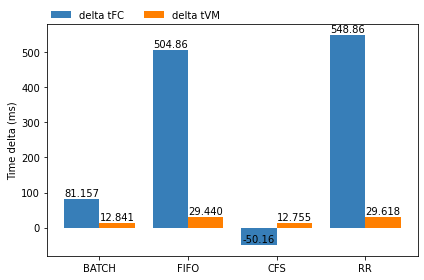

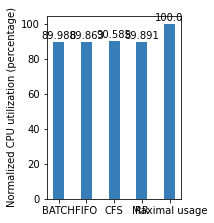

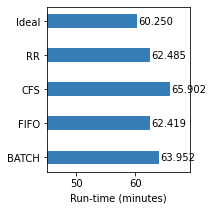

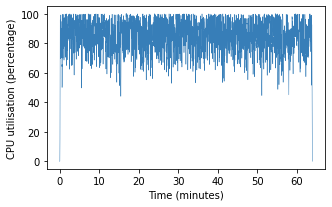

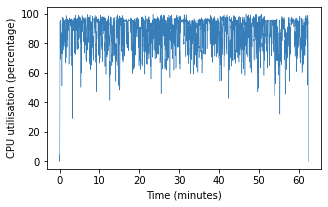

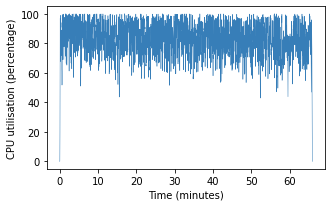

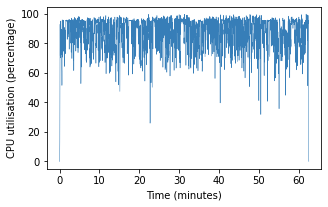

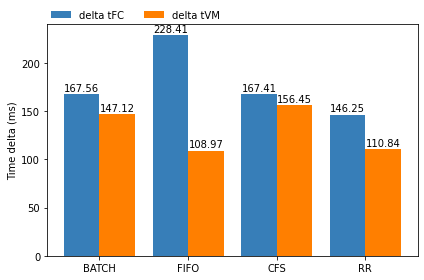

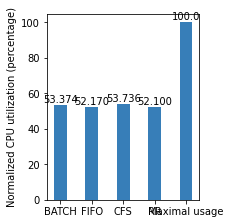

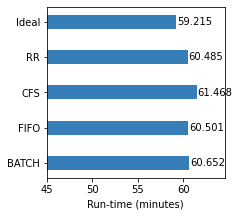

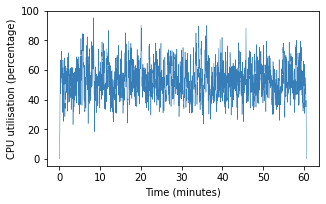

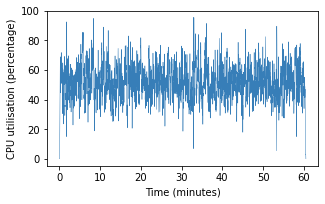

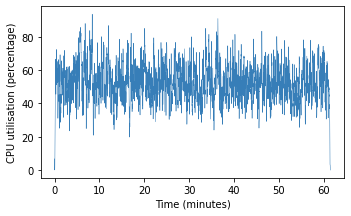

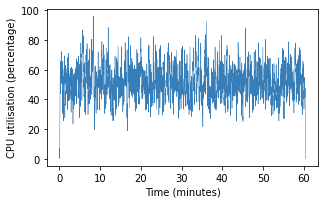

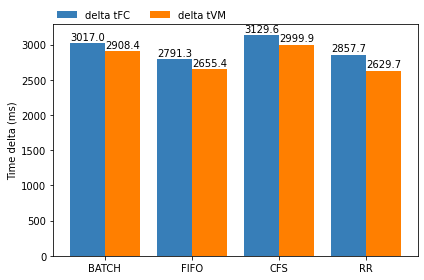

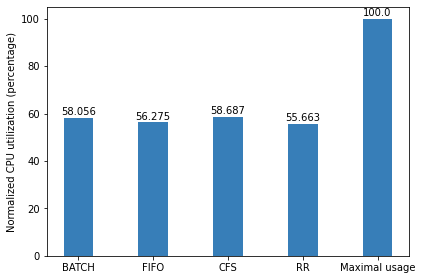

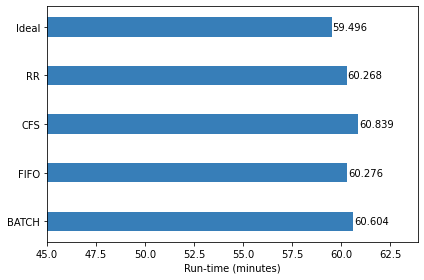

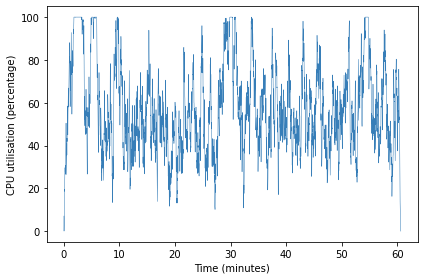

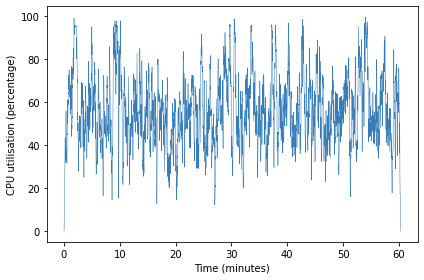

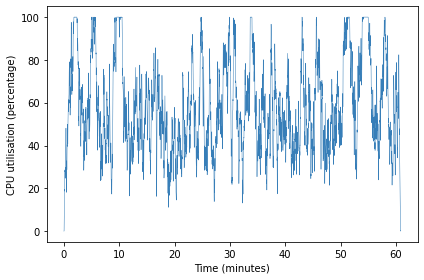

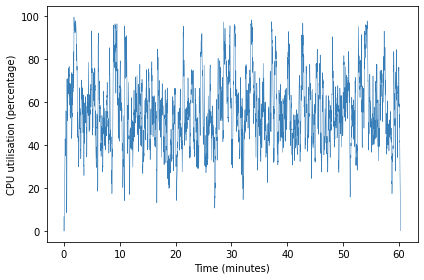

In [7]:
# descriptive statistics cell

%matplotlib inline

all_figs = []
all_axes = []


MIN_SEC = 60
MIN_MSEC = MIN_SEC*1000
HOUR_SEC  = 60*60
HOUR_MSEC = HOUR_SEC*1000

def my_maximal_cpu_usage(minute: float) -> float:
    if minute >= 5.0 and minute <= 55.0:
        # Between 5 and 55 minutes -> full CPU usage
        return 100.0
    elif minute >= 60.0:
        return 0.0
    elif minute <= 0.0:
        return 0.0
    elif minute < 5.0:
        return min(44*minute - 4.8 * minute*minute, 100.0)
    elif minute > 55.0:
        return min(- 14640 + 532*minute - minute*minute * 4.8, 100.0)
    
ideal_usage_seconds = [i for i in range(0, HOUR_SEC + 1, 1)]
ideal_usage = [my_maximal_cpu_usage(i / MIN_SEC) for i in ideal_usage_seconds]

for machine in machine_workload_sched:
#     # Skip others for now
    if machine != "c5n":# and machine != "apollo":
        continue
        
    cur_axes = []
    cur_figs = []
    
    for workload in machine_workload_sched[machine]:
#         # Skip others for now
        if workload != "poisson-12500-1hr-mem" and workload != "poisson-50000-1hr-cpu" and workload != "poisson-25000-1hr-75cpu25mem":
            continue

        # lists for gathering the data
        deltavm = []
        deltafc = []
        auc_sys = []
        
        # store the auc's of total sys cpu time and user cpu time
        cpu_sys_user = []
        cpu_usage_graph_data = []
        runtimes = []

        bar_width = 0.4

        for result in machine_workload_sched[machine][workload]["results"]:
            # collect some basic metrics
            deltavm.append((result[0], result[1]["d tVM"].mean()))
            deltafc.append((result[0], result[1]["d tFC"].mean()))
            runtimes.append([result[0], result[1]["end time"].max()])
            
            # sysmon is not always present
            if result[2] is not None:
                # Normalize the sysmon times
                result[2]["t"] = result[2]["t"] - result[2]["t"].min()
                
                # Use a tuple here, as sysmon readings are optional
                # so we must know whether the result+sched has a sysmon
                auc_sys.append((result[0], simpson(result[2]["cpu_percentage"], result[2]["t"])))
                cpu_sys_user.append((result[0], simpson(result[2]["cpu_system"]), simpson(result[2]["cpu_user"])))
                
                cpu_usage_graph_data.append((result[0], result[2]["t"] - result[2]["t"][0], result[2]["cpu_percentage"]))
#             else:
#                 auc_sys.append((result[0], "None"))
#                 cpu_sys_user.append(())
                
                
        #Create figures
        deltafig, deltaax = plt.subplots()
        cur_axes.append(deltaax)
        cur_figs.append(("time-delta", deltafig))
        
        my_bar_plot(deltaax, [ [x[1] for x in deltafc], [y[1] for y in deltavm] ], 
                    [s[0] for s in deltafc], "Time delta (ms)", ["delta tFC", "delta tVM"],
                    f"delta plot of {machine} {workload}")
        
        # Set all for the sysmon plot (not always present)
        if auc_sys:
            sysfig, sysax = plt.subplots()
            cur_axes.append(sysax)
            cur_figs.append(("AUC", sysfig))

            # Normalize the values by using the ideal
            y_values = [val[1] for val in auc_sys]
            
            y_max = max(y_values)
            
            # Append 'ideal' AUC (100% usage over 1hr
            y_ideal = 100.0 * HOUR_SEC
            y_values.append(y_ideal)
            auc_sys.append(("Maximal usage", y_ideal, HOUR_SEC))

            my_bar_plot(sysax, [ (y/y_ideal) * 100 for y in y_values ],
                        [s[0] for s in auc_sys], "Normalized CPU utilization (percentage)",
                        "AUC", f"cpu auc {machine} {workload}")
            
            sysax.get_legend().remove()
        
        # Create the bars with runtimes
        runfig, runax = plt.subplots()
        cur_figs.append(("runtime", runfig))
        cur_axes.append(runax)
        
        # collect predicted runtimes
        for i, lst in enumerate(runtimes):
            pred = pd.read_csv(machine_workload_sched[machine][workload]["predictions"][lst[0]], comment="#", skipinitialspace=True)
            
            pred_runtime = pred["pred. end time"].max()
            runtimes[i].append(pred_runtime)
            
        # Pick one prediction as the 'ideal' (no point in showing them all as they vary little)
        ideal_time = reduce(lambda x, y: x + y, [prediction for _, _, prediction in runtimes]) / len(runtimes)
        runtimes.append(["Ideal", ideal_time, ideal_time])

        # Determine largest and smallest runtime
        tmp = [runtime for _, runtime, _ in runtimes]
        shortest_runtime = min(tmp) / MIN_MSEC
        longest_runtime = max(tmp) / MIN_MSEC
        del tmp
    
              
        my_bar_plot(runax, [ ( (runtime / MIN_MSEC) ) for _, runtime, _ in runtimes],
                    [s[0] for s in runtimes], "Run-time (minutes)", "Runtime",
                    f"runtimes {machine} {workload}", "h")
#         runax.margins(x=0.11)
        runax.get_legend().remove()
        runax.set_xlim(xmin=45)

        cells = [["Scheduler", "Ratio"] ]
        cells = cells + [ [x[0], f"{round((x[2]/x[1]), 3)}"] for x in cpu_sys_user]
        
        for i, (sched, t, cpu_percentage) in enumerate(cpu_usage_graph_data):
            # Plot usage figures
            usage_fig, usage_ax = plt.subplots()
            cur_figs.append((f"cpu-util-{sched}", usage_fig))
#             cpu_usage_graph_data.append(("Maximal usage", pd.DataFrame(ideal_usage_seconds), pd.DataFrame(ideal_usage)))
    
            usage_ax.plot((t / MIN_SEC), cpu_percentage, linestyle="-", linewidth=0.5, marker="", label=sched, alpha=1.0)
            usage_ax.set_ylabel("CPU utilisation (percentage)")
            usage_ax.set_xlabel("Time (minutes)")
        
        
        for ax in cur_axes:
#             ax.margins(0.1)
            ax.autoscale_view()
            
        for figtype, fig in cur_figs:
            fig.tight_layout()
            save_my_figure(fig, figtype, machine, workload)
#             plt.close(fig=fig)
        
        
        
    all_axes = all_axes + cur_axes
    all_figs = all_figs + [f[1] for f in cur_figs]
    


poisson-25000-1hr-mem [data(scheduler='BATCH', variance_tFC=945168451.3602896, variance_tVM=482326690.3200633, cvar_tFC=0.3162172599777504, cvar_tVM=0.3316765226584368, ratio_tFC_tVM=1.468294328854493), data(scheduler='CFS', variance_tFC=365635406.7846411, variance_tVM=190224332.12712646, cvar_tFC=0.3454049164526496, cvar_tVM=0.3691553009787989, ratio_tFC_tVM=1.4817388998429473), data(scheduler='RR', variance_tFC=1340864883.4391239, variance_tVM=19477219.6788922, cvar_tFC=0.2911914793762469, cvar_tVM=0.657762166505346, ratio_tFC_tVM=18.742143306198297)]
poisson-50000-1hr-cpu [data(scheduler='BATCH', variance_tFC=10240.09629812335, variance_tVM=1864.119891361719, cvar_tFC=0.018419982225966924, cvar_tVM=0.02112019257395981, ratio_tFC_tVM=2.68734711939465), data(scheduler='FIFO', variance_tFC=1407099.0894536609, variance_tVM=4058.9918296556443, cvar_tFC=0.19661417700540323, cvar_tVM=0.030883649050683252, ratio_tFC_tVM=2.924603742194515), data(scheduler='CFS', variance_tFC=6579.28986168843

<ipython-input-16-d44bd32c2b29>:122: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparant" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(figure_loc, transparant=False, facecolor="w", bbox_inches="tight", dpi=300)
<ipython-input-16-d44bd32c2b29>:122: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparant" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(figure_loc, transparant=False, facecolor="w", bbox_inches="tight", dpi=300)


poisson-25000-1hr-75cpu25mem [data(scheduler='BATCH', variance_tFC=6645.248394389214, variance_tVM=5621.3731217939985, cvar_tFC=0.019535684579806062, cvar_tVM=0.11204196739246713, ratio_tFC_tVM=6.2357184028692), data(scheduler='FIFO', variance_tFC=959807.5942848064, variance_tVM=6877.919738526488, cvar_tFC=0.22907387759601489, cvar_tVM=0.1221484661349021, ratio_tFC_tVM=6.299063545901119), data(scheduler='CFS', variance_tFC=6724.7190240138, variance_tVM=5741.924485904943, cvar_tFC=0.019625244734765478, cvar_tVM=0.11239556959256067, ratio_tFC_tVM=6.197869740568869), data(scheduler='RR', variance_tFC=20628.448344455035, variance_tVM=5624.5817023015115, cvar_tFC=0.03429046533362068, cvar_tVM=0.11133034725286221, ratio_tFC_tVM=6.217679775153819)]
poisson-12500-1hr-mem [data(scheduler='BATCH', variance_tFC=585641.7648317666, variance_tVM=272178.65285333607, cvar_tFC=0.16108240481195413, cvar_tVM=0.4639545588147938, ratio_tFC_tVM=4.224899008703344), data(scheduler='FIFO', variance_tFC=353546.

<ipython-input-16-d44bd32c2b29>:122: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparant" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(figure_loc, transparant=False, facecolor="w", bbox_inches="tight", dpi=300)
<ipython-input-16-d44bd32c2b29>:122: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparant" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(figure_loc, transparant=False, facecolor="w", bbox_inches="tight", dpi=300)


poisson-50000-1hr-mem [data(scheduler='FIFO', variance_tFC=2173114016.3590117, variance_tVM=32223842.051438484, cvar_tFC=0.3230969331299862, cvar_tVM=0.9706578097769223, ratio_tFC_tVM=24.670952317431883), data(scheduler='CFS', variance_tFC=894308725.2446067, variance_tVM=456381256.50140333, cvar_tFC=0.6449529174497677, cvar_tVM=0.6932038318460882, ratio_tFC_tVM=1.504571313449419)]


<ipython-input-16-d44bd32c2b29>:122: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparant" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(figure_loc, transparant=False, facecolor="w", bbox_inches="tight", dpi=300)


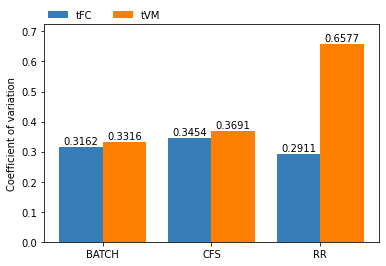

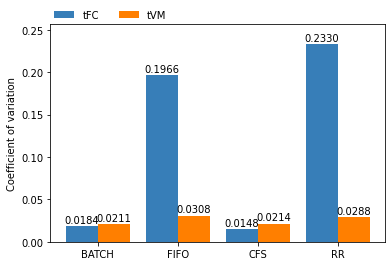

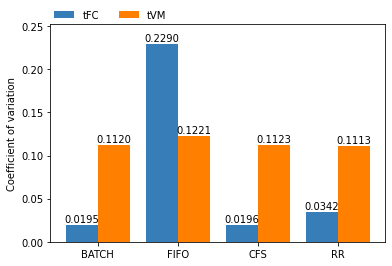

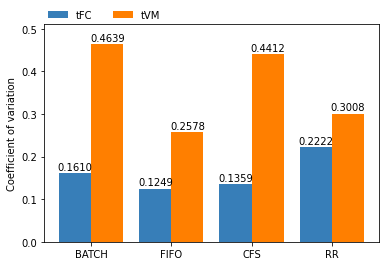

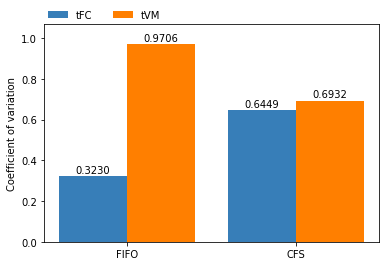

In [19]:
# numerical analysis cell

%matplotlib inline

from collections import namedtuple

data_tuple = namedtuple("data", ["scheduler", "variance_tFC", "variance_tVM", "cvar_tFC", "cvar_tVM", "ratio_tFC_tVM"])


for machine in machine_workload_sched:
    # Skip others for now
    if machine != "c5n":# and machine != "apollo":
        continue
        
    cur_axes = []
    cur_figs = []
    
    for workload in machine_workload_sched[machine]:
            
        if workload != "poisson-12500-1hr-mem" and workload != "poisson-50000-1hr-cpu" and workload != "poisson-25000-1hr-75cpu25mem":
            continue
            
        data = []
        
        fig_var, ax_var = plt.subplots()
        
        for sched, df, _ in machine_workload_sched[machine][workload]["results"]:
            # we pick a (workloadid, argument) tuple
            wid, arg = -1, -1
            if "mem" in workload:
                wid, arg = 2, 20
            elif "cpu" in workload:
                wid, arg = 0,5500000
                
            df = df[ (df["workloadID"] == wid) & (df["workload argument"] == arg)]
            
#             for i, lst in enumerate(runtimes):
#                 pred = pd.read_csv(machine_workload_sched[machine][workload]["predictions"][lst[0]], comment="#", skipinitialspace=True)
#                 pred = pred[ (pred["workloadID"] == wid) & (pred["workload argument"] == arg) ]
                
            #Calculate the variance between each execution of wid, arg
            var_tFC = df["tFC"].var()
            var_tVM = df["tVM"].var()
            
            std_tFC = df["tFC"].std()
            std_tVM = df["tVM"].std()
            mean_tFC = df["tFC"].mean()
            mean_tVM = df["tVM"].mean()
            
            cvar_tFC = std_tFC / mean_tFC
            cvar_tVM = std_tVM / mean_tVM

            ratio = df["tFC"].mean() / df["tVM"].mean()

            data.append(data_tuple(scheduler=sched, variance_tFC=var_tFC, variance_tVM=var_tVM, cvar_tFC=cvar_tFC, cvar_tVM=cvar_tVM, ratio_tFC_tVM=ratio))
            
        print(workload, data)
        my_bar_plot(ax_var, [ [d.cvar_tFC for d in data], [d.cvar_tVM for d in data] ], 
                    [d.scheduler for d in data], "Coefficient of variation", ["tFC", "tVM"])
        save_my_figure(fig_var, "co-var", machine, workload)
        
    
# for workload in machine_workload_sched["c5n"]:
#     print(f"{workload}")
#     headers = data_tuple._fields
#     print(" \t ".join(headers))

#     for res in tmp["c5n"][workload]:
#         for i, field in enumerate(res):
#             #Not rounding properly, but I don't mind for this preliminary result
#             s = str(field)[0:len(headers[i])]
#             spaces = len(headers[i]) - len(s)
#             if spaces > 0:
#                 s = s + "".join(" " for i in range(spaces))
#             print(f"{s} \t ", end="")
#         print("")

    

c5n poisson-50000-1hr-cpu


<ipython-input-16-d44bd32c2b29>:122: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparant" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(figure_loc, transparant=False, facecolor="w", bbox_inches="tight", dpi=300)


c5n poisson-25000-1hr-75cpu25mem


<ipython-input-16-d44bd32c2b29>:122: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparant" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(figure_loc, transparant=False, facecolor="w", bbox_inches="tight", dpi=300)


c5n poisson-12500-1hr-mem


<ipython-input-16-d44bd32c2b29>:122: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparant" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(figure_loc, transparant=False, facecolor="w", bbox_inches="tight", dpi=300)


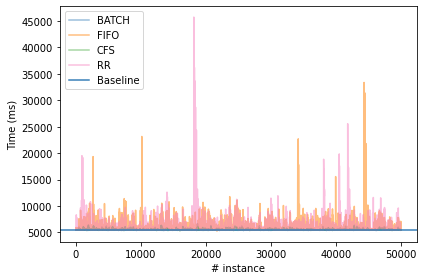

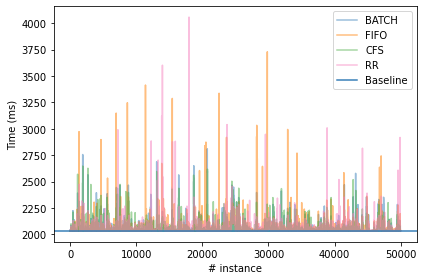

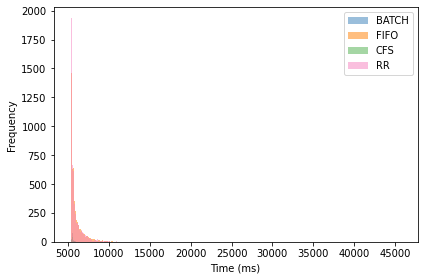

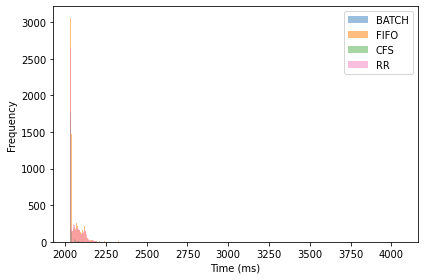

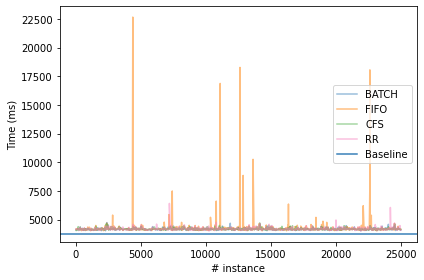

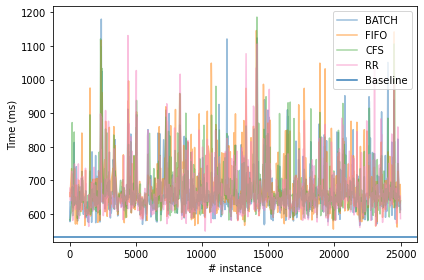

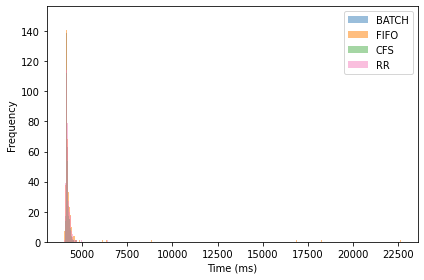

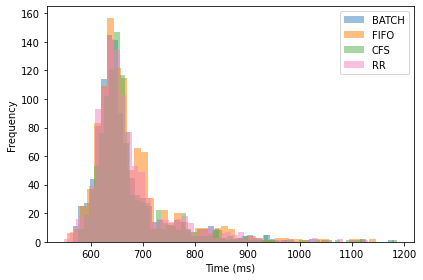

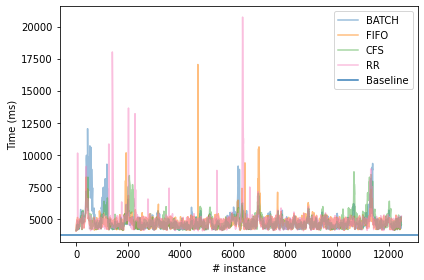

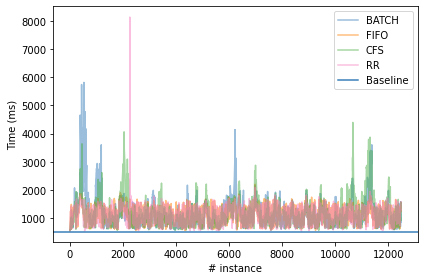

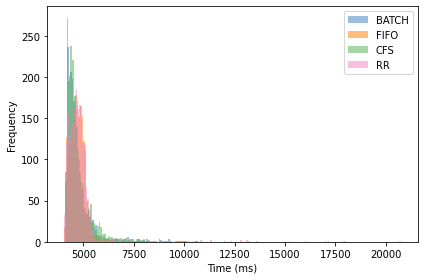

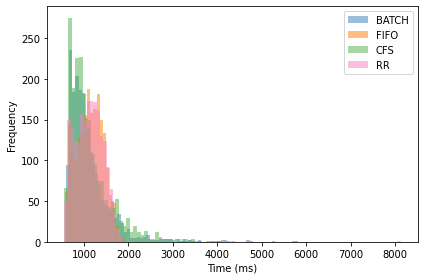

In [25]:
%matplotlib inline

#  Plot runtimes of each equal (workloadID, workload_argument)

for machine in machine_workload_sched:
    # Skip others for now
    if machine != "c5n":# and machine != "apollo":
        continue
        
    cur_axes = []
    cur_figs = []
    
    for workload in machine_workload_sched[machine]:
        if workload != "poisson-12500-1hr-mem" and workload != "poisson-50000-1hr-cpu" and workload != "poisson-25000-1hr-75cpu25mem":
            continue
            
        data = []
        
        # Aggregate all schedulers in one figure
        fig_t_fc, ax_fc = plt.subplots()
        fig_t_vm, ax_vm = plt.subplots()
        fig_h_fc, hg_fc = plt.subplots()
        fig_h_vm, hg_vm = plt.subplots()
        
        all_axes = [
                    (ax_vm, "graph"),
                    (ax_fc, "graph"),
                    (hg_vm, "histo"),
                    (hg_fc, "histo")
                   ]
        all_figs = [
                    (fig_t_fc, "individual-runtimes-fc"),
                    (fig_t_vm, "individual-runtimes-vm"),
                    (fig_h_fc, "individual-rt-hist-fc"),
                    (fig_h_vm, "individual-rt-hist-vm"),]
        
        # Collect baseline values for tVM and tFC
        baseline_paths = []
        for sched in machine_workload_sched[machine][workload]["predictions"]:
            basepath = path.dirname(machine_workload_sched[machine][workload]["predictions"][sched])
            
            baselines = recursive_file_search(basepath, find_baselines)
            baseline_paths += baselines
            
        avg_baselines = calculate_average_baselines(files=baseline_paths)
        
        print(f"{machine} {workload}")
        # TODO: Change the drawing order, such that the lowest values on the y axis are visible
        for sched, df, df_sysmon in machine_workload_sched[machine][workload]["results"]:         
            wid, arg = -1, -1
            if "mem" in workload:
                wid, arg = 2, 20
            elif "cpu" in workload:
                wid, arg = 0,5500000
                
            df = df[ (df["workloadID"] == wid) & (df["workload argument"] == arg)]
            
            # plot the runtimes for each measured run-time
            ax_vm.plot(df.index, df["tVM"], label=sched, alpha=0.5)
            ax_fc.plot(df.index, df["tFC"], label=sched, alpha=0.5)
            
            # Plot the histograms
            my_execution_histogram(hg_vm, df["tVM"], sched, "tVM (milliseconds)")
            my_execution_histogram(hg_fc, df["tFC"], sched, "tFC (milliseconds)")
            
            
        bl_fc, bl_vm = avg_baselines[wid][arg]
        ax_vm.axhline(bl_vm, label="Baseline")
#         ax_vm.set_ylim(ymin=round_to_largest_significant_num(bl_vm))
        ax_fc.axhline(bl_fc, label="Baseline")    
#         ax_fc.set_ylim(ymin=round_to_largest_significant_num(bl_fc))

        for ax, ax_type in all_axes:
            ax.legend()
            if ax_type == "graph":
                ax.set_xlabel("# instance")
                ax.set_ylabel("Time (ms)")
            elif ax_type == "histo":
                ax.set_xlabel("Time (ms)")
                ax.set_ylabel("Frequency")
            
        for fig, figtype in all_figs:
            fig.tight_layout()
            save_my_figure(fig, figtype, machine, workload)

<ipython-input-4-56d37a555a2b>:122: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparant" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(figure_loc, transparant=False, facecolor="w", bbox_inches="tight", dpi=300)


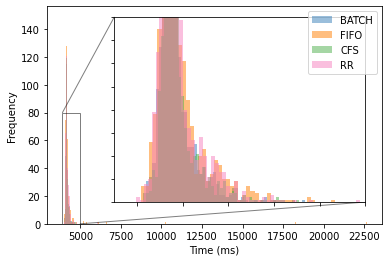

In [34]:
%matplotlib inline

# Create insets of the unclear plots of above
machine = "c5n"
workload = "poisson-25000-1hr-75cpu25mem"

inset_fig, hg_ax = plt.subplots()
inset_ax = hg_ax.inset_axes([0.2,0.1,0.75,0.85])

for sched, df, df_sysmon in machine_workload_sched[machine][workload]["results"]:  
    wid, arg = -1, -1
    if "mem" in workload:
        wid, arg = 2, 20
    elif "cpu" in workload:
        wid, arg = 0,5500000

    

    df = df[ (df["workloadID"] == wid) & (df["workload argument"] == arg)]
    my_execution_histogram(hg_ax, df["tFC"], sched, "tFC (milliseconds)")
    my_execution_histogram(inset_ax, df["tFC"], "", "")

inset_ax.set_xlim(3900,5000)
inset_ax.set_ylim(0,80)
inset_ax.set_ylabel("")
inset_ax.set_xticklabels("")
inset_ax.set_yticklabels("")

hg_ax.legend()
hg_ax.indicate_inset_zoom(inset_ax, edgecolor="black")
hg_ax.set_xlabel("Time (ms)")
hg_ax.set_ylabel("Frequency")


save_my_figure(inset_fig, "inset-individual-rt-hist-fc", machine, workload)